# Process Historical Fire Perimeters

## Scope

In [1]:
import geopandas as gpd
import fiona
import os
import zipfile
import rasterio
import numpy as np
from rasterio.features import rasterize
from rasterio.transform import from_origin
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import contextily as ctx
import ipywidgets as widgets
from IPython.display import display
import shapely

# Read in fire perimeters overlapping Malneur boundary and investigate gdf

In [2]:
mnf_fires_all = gpd.read_file(r"../downloaded_data/mnf_fires_all.geojson") # Adjust paths to account for working directory
mnf_bounds = gpd.read_file(r"../downloaded_data/mnf_bounds.geojson")

In [3]:
mnf_fires_all.head()

,OBJECTID,MAP_METHOD,DATE_CUR,COMMENTS,GEO_ID,IRWINID,UNQE_FIRE_,FIRE_YEAR,LOCAL_NUM,INCIDENT,...,SOURCE,AGENCY,FIRE_YEAR_,Shape__Are,Shape__Len,FORID,OTHERID,index_right,FORESTNAME,geometry
0,3326,Digitized-Other,200805290000,Added from 1MM Scale recitifed image,{C8DD94E6-A1D3-4862-8BDD-7E0D26B16DF5},None,1910-ORMAF-000031,1910,None,1910 Fire 31,...,USFS,USFS,1910,9.766016e+07,36910.349331,None,None,65.0,Malheur National Forest,"POLYGON ((-13220752.497 5441600.566, -13220881..."
1,3335,Digitized-Other,200805290000,Added from 1MM Scale recitifed image,{05EBF502-3A99-4DAD-90F1-334E43A9BB2A},None,1910-ORMAF-000027,1910,None,1910 Fire 27,...,USFS,USFS,1910,1.524486e+08,48956.458053,None,None,65.0,Malheur National Forest,"POLYGON ((-13204840.04 5513395.884, -13204789...."
2,32469,Digitized-Other,200805290000,Added from 1MM Scale recitifed image,{61D7987C-830C-4F28-BB5E-37F57D6EB9A6},None,1910-ORMAF-000028,1910,None,1910 Fire 28,...,USFS,USFS,1910,1.658106e+08,53060.785589,None,None,65.0,Malheur National Forest,"POLYGON ((-13171332.211 5500377.617, -13171139..."
3,32222,Digitized-Other,200805290000,Added from 1MM Scale recitifed image,{13F5D629-6558-494F-A6F5-4E09855091F8},None,1910-ORMAF-000030,1910,None,1910 Fire 30,...,USFS,USFS,1910,5.960445e+08,98028.967171,None,None,65.0,Malheur National Forest,"POLYGON ((-13285286.835 5421104.687, -13289558..."
4,32192,Digitized-Other,200805290000,Added from 1MM Scale recitifed image,{E70A5124-AAFE-437E-A824-690872FB9F18},None,1910-ORMAF-000025,1910,None,1910 Fire 25,...,USFS,USFS,1910,1.765018e+08,51860.411857,None,None,65.0,Malheur National Forest,"POLYGON ((-13264432.376 5547406.561, -13267574..."


In [4]:
mnf_fires_all.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 216 entries, 0 to 215
Data columns (total 25 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   OBJECTID     216 non-null    int32   
 1   MAP_METHOD   216 non-null    object  
 2   DATE_CUR     216 non-null    object  
 3   COMMENTS     43 non-null     object  
 4   GEO_ID       215 non-null    object  
 5   IRWINID      44 non-null     object  
 6   UNQE_FIRE_   201 non-null    object  
 7   FIRE_YEAR    216 non-null    object  
 8   LOCAL_NUM    94 non-null     object  
 9   INCIDENT     216 non-null    object  
 10  UNIT_ID      214 non-null    object  
 11  POO_RESP_I   150 non-null    object  
 12  FEATURE_CA   216 non-null    object  
 13  GIS_ACRES    216 non-null    float64 
 14  USER_NAME    2 non-null      object  
 15  SOURCE       216 non-null    object  
 16  AGENCY       216 non-null    object  
 17  FIRE_YEAR_   216 non-null    int32   
 18  Shape__Are   216 non-n

**216 fires before cleaning**

In [5]:
# Clean and prepare gdf for analysis
# Convert FIRE_YEAR to numeric to handle errors and allow mathematical calculations
mnf_fires_all["FIRE_YEAR"] = pd.to_numeric(mnf_fires_all["FIRE_YEAR"], errors = "coerce") 

# Get unique values as a sorted list to check for anomalous values
unique_years = sorted(mnf_fires_all["FIRE_YEAR"].unique()) # List unique values of year
print(unique_years)

[np.int64(1910), np.int64(1939), np.int64(1958), np.int64(1960), np.int64(1962), np.int64(1967), np.int64(1968), np.int64(1972), np.int64(1974), np.int64(1977), np.int64(1979), np.int64(1981), np.int64(1984), np.int64(1986), np.int64(1987), np.int64(1988), np.int64(1989), np.int64(1990), np.int64(1991), np.int64(1992), np.int64(1994), np.int64(1995), np.int64(1996), np.int64(1997), np.int64(1998), np.int64(2000), np.int64(2001), np.int64(2002), np.int64(2003), np.int64(2005), np.int64(2006), np.int64(2007), np.int64(2008), np.int64(2009), np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023)]


In [6]:
all_records_count = len(mnf_fires_all)
first_fire_year = mnf_fires_all.iloc[0]["FIRE_YEAR"]
first_incident = mnf_fires_all.iloc[0]["INCIDENT"]
last_fire_year = mnf_fires_all.iloc[-1]["FIRE_YEAR"]
last_incident = mnf_fires_all.iloc[-1]["INCIDENT"]

In [7]:
# Define the dictionary with string keys
data_summary = {
    "all_records_count": all_records_count,
    "first_incident": first_incident,
    "first_fire_year": first_fire_year,
    "last_incident": last_incident,
    "last_fire_year": last_fire_year
}

# Format the text correctly
summary_text = '''The NIFC Historic Fire Perimeter dataset contains {all_records_count} incident records within Malheur National Forest.
The oldest valid record is for the {first_incident} incident {first_fire_year}. 
The newest valid record is for the {last_incident} incident in {last_fire_year}.
'''.format(**data_summary)

# Print the formatted text
print(summary_text)

The NIFC Historic Fire Perimeter dataset contains 216 incident records within Malheur National Forest.
The oldest valid record is for the 1910 Fire 31 incident 1910. 
The newest valid record is for the Lost Spring incident in 2023.



# Prepare to subset mnf_fires_all

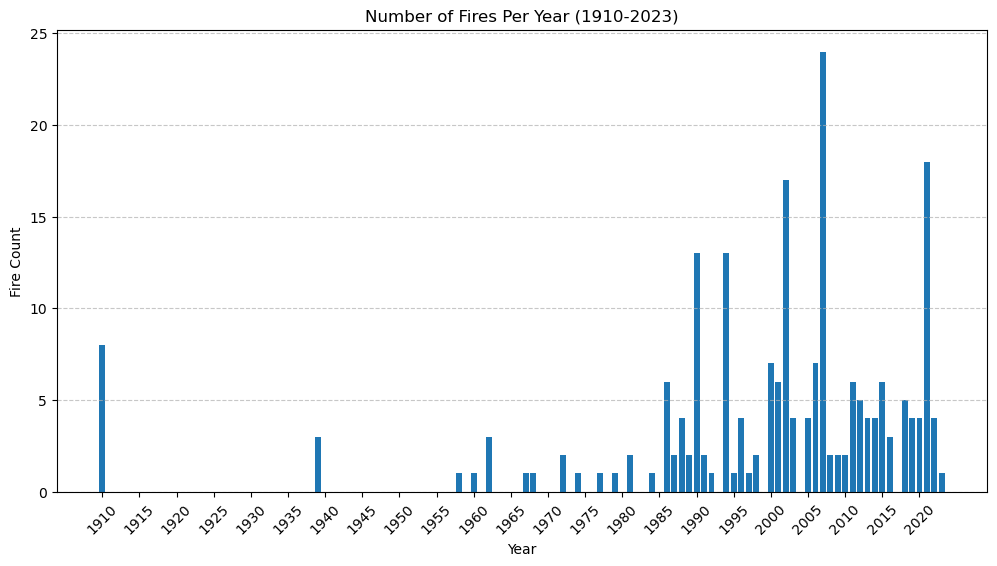

In [8]:
# Group by year and count occurrences
fires_per_year = mnf_fires_all.groupby('FIRE_YEAR').size().reset_index(name = 'count')

year_range = pd.DataFrame({'FIRE_YEAR': range(1910, 2024)})
fires_per_year = year_range.merge(fires_per_year, on="FIRE_YEAR", how="left").fillna(0)
fires_per_year["count"] = fires_per_year["count"].astype(int)

plt.figure(figsize=(12, 6))
plt.bar(fires_per_year["FIRE_YEAR"], fires_per_year["count"])
plt.xlabel("Year")
plt.ylabel("Fire Count")
plt.title("Number of Fires Per Year (1910-2023)")
tick_positions = np.arange(1910, 2025, 5)  # Every 5 years
plt.xticks(tick_positions, rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

The fires in 1910 and 1939 are well recorded and have sizable overlap with later fires, so they weill be kept in the dataset. However, the absence of records for the intervening years between records, especially prior to the 1950s, should not be assumed to indicate a lack of fire but instead a potential lack of /recorded/ fire. While the larger dataset does include fires going back to the 8th century mapped using carbon dating, there very well may be fires that occured within Malheur that went unrecorded or even unnoticed. While Malheur was designated a National Forest in 1908, it was not exactly a hot destination for recreators at the time. Future studies of historical sources or further investigation of natural markers of fire history (e.g., fire scars, pollen record, soil cores) may reveal unknown fires. 

However, it is also likely that there were in fact few to zero fires in the early 20th century due to the aggressive fire exclusion and suppression approaches to forest management employed by the Forest Service. Ultimately, it may not be possible to ever consider this dataset truly complete or known how close to complete it actually is. That being said, it is a rich source of spatially explicit data that allows us to begin untangling complex interactions between disturbance agents on a landscape. 

## QA/QC fire perimeters in mnf_fires_all

In [9]:
'''Since we are planning to calculate spatial statistics based on the frequency of and time between fires, we need to make sure that there are no duplicate records skewing the stats.
This dataset has a known issue with duplicate perimeters submitted by different agencies (usually USFS and BLM) with slightly different incident names, calculated areas, and shapes. 
The QA/QC steps in this section are aimed at weeding out as many of those duplicates as possible without manual review of all 216 records. First, we identify all features in 
mnf_fires_all that overlap another feature in the dataset. From these, records with the same "INCIDENT" and "FIRE_YEAR" are culled, keeping the first record; preference is given to records submitted by the USFS
where available as they are the primary fire managers in the region of interest and maintain many of the current fire perimeter datasets that this one is derived from. Next, the remaining overlapping features 
are 
 '''


'Since we are planning to calculate spatial statistics based on the frequency of and time between fires, we need to make sure that there are no duplicate records skewing the stats.\nThis dataset has a known issue with duplicate perimeters submitted by different agencies (usually USFS and BLM) with slightly different incident names, calculated areas, and shapes. \nThe QA/QC steps in this section are aimed at weeding out as many of those duplicates as possible without manual review of all 216 records. First, we identify all features in \nmnf_fires_all that overlap another feature in the dataset. From these, records with the same "INCIDENT" and "FIRE_YEAR" are culled, keeping the first record; preference is given to records submitted by the USFS\nwhere available as they are the primary fire managers in the region of interest and maintain many of the current fire perimeter datasets that this one is derived from. Next, the remaining overlapping features \nare \n '

In [10]:
'''
# Define colors
fill_color = "#CC5500"  # Burnt Orange (fire perimeters)
edge_color = "#993300"  # Dark Orange (fire outlines)
boundary_edge_color = "#006400"  # Dark Green (Malheur boundary)

# Ensure GeoDataFrames are in Web Mercator (EPSG:3857) for basemap compatibility
mnf_fires_all = mnf_fires_all.to_crs(epsg=3857)
mnf_bounds = mnf_bounds.to_crs(epsg=3857)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the fire perimeters
mnf_fires_all.plot(ax=ax, color=fill_color, edgecolor=edge_color, alpha=0.6, linewidth=0.8)

# Plot Malheur National Forest boundary with no fill, only dark green outline
mnf_bounds.plot(ax=ax, color="none", edgecolor=boundary_edge_color, linewidth=2)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=10, alpha=0.8)

# Add a custom legend
legend_patches = [
    mpatches.Patch(color=fill_color, label="Incident Perimeter", alpha=0.6, edgecolor=edge_color),
    mpatches.Patch(color="none", edgecolor=boundary_edge_color, label="Malheur National Forest Boundary", linewidth=2)
]
ax.legend(handles=legend_patches, loc="upper right")

# Title and axis labels
ax.set_title("All Malheur National Forest Fire Incidents (1910-2023)", fontsize=14)

# Remove axis labels (optional, since basemap provides context)
ax.set_xticks([])
ax.set_yticks([])

# Show plot
plt.show()
'''

'\n# Define colors\nfill_color = "#CC5500"  # Burnt Orange (fire perimeters)\nedge_color = "#993300"  # Dark Orange (fire outlines)\nboundary_edge_color = "#006400"  # Dark Green (Malheur boundary)\n\n# Ensure GeoDataFrames are in Web Mercator (EPSG:3857) for basemap compatibility\nmnf_fires_all = mnf_fires_all.to_crs(epsg=3857)\nmnf_bounds = mnf_bounds.to_crs(epsg=3857)\n\n# Create the figure and axis\nfig, ax = plt.subplots(figsize=(10, 8))\n\n# Plot the fire perimeters\nmnf_fires_all.plot(ax=ax, color=fill_color, edgecolor=edge_color, alpha=0.6, linewidth=0.8)\n\n# Plot Malheur National Forest boundary with no fill, only dark green outline\nmnf_bounds.plot(ax=ax, color="none", edgecolor=boundary_edge_color, linewidth=2)\n\n# Add basemap\nctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=10, alpha=0.8)\n\n# Add a custom legend\nlegend_patches = [\n    mpatches.Patch(color=fill_color, label="Incident Perimeter", alpha=0.6, edgecolor=edge_color),\n    mpatches.Patch(c

In [11]:
# Identify and reconcile overlapping fires
'''
Iterates through features to identify incidents that share the same year and have overlapping geometries.
Handles duplicate records for features with >90% overlapping geometries: Exact matches retain USFS record 
when applicable or larger incident, and non-exact matches with >90% overlap retain the larger incident. If there is <=90% overlap
and no match on INCIDENT, then the incident is added to a list for manual review.
Returns a gdf with duplicates removed and a gdf with a list of overlapping incident pairs for manual review.
'''
def process_overlapping_fires(df):
    df = df.copy()
    df["area"] = df.geometry.area  # Compute area for overlap calculations
    to_review = []
    to_remove = set()
    
    for i, fire in df.iterrows():
        overlapping_fires = df[(df['FIRE_YEAR'] == fire['FIRE_YEAR']) & (df.index != i) & (df.intersects(fire.geometry))] # Subset all incidents that share a FIRE_YEAR and that intersect
        
        for j, overlap in overlapping_fires.iterrows():
            intersection_area = fire.geometry.intersection(overlap.geometry).area
            fire_overlap_pct = intersection_area / fire.area
            overlap_overlap_pct = intersection_area / overlap.area
            
            # If INCIDENT names match, prefer USFS or largest fire
            if fire["INCIDENT"] == overlap["INCIDENT"]:
                if fire["AGENCY"] == "USFS":
                    to_remove.add(j)
                elif overlap["AGENCY"] == "USFS":
                    to_remove.add(i)
                else:
                    to_remove.add(i if fire["GIS_ACRES"] < overlap["GIS_ACRES"] else j)
            
            # If >90% overlap, prefer USFS or largest fire
            elif fire_overlap_pct > 0.9 and overlap_overlap_pct > 0.9:
                if fire["AGENCY"] == "USFS":
                    to_remove.add(j)
                elif overlap["AGENCY"] == "USFS":
                    to_remove.add(i)
                else:
                    to_remove.add(i if fire["GIS_ACRES"] <= overlap["GIS_ACRES"] else j)
            
            # If less than 90% overlap, add to review list
            else:
                to_review.append({
                    "FIRE_YEAR": fire['FIRE_YEAR'],
                    "INCIDENT_1": fire['INCIDENT'], "AGENCY_1": fire['AGENCY'], "geometry_1": fire['geometry'],
                    "INCIDENT_2": overlap['INCIDENT'], "AGENCY_2": overlap['AGENCY'], "geometry_2": overlap['geometry']
                })
    
    df_cleaned = df.drop(index=list(to_remove))
    return df_cleaned, gpd.GeoDataFrame(to_review, geometry="geometry_1", crs=df.crs)

mnf_fires_cleaned, overlapping_mnf_fires = process_overlapping_fires(mnf_fires_all)

In [12]:
# These are the remaining incidents requiring manual review
overlapping_mnf_fires

,FIRE_YEAR,INCIDENT_1,AGENCY_1,geometry_1,INCIDENT_2,AGENCY_2,geometry_2
0,1990,Whiting Springs,USFS,"POLYGON ((-13252376.493 5426819.177, -13253831...",Whiting Sp,BLM,"POLYGON ((-13254592.3085 5423161.3706, -132546..."
1,1990,Whiting Sp,BLM,"POLYGON ((-13254592.308 5423161.371, -13254692...",Whiting Springs,USFS,"POLYGON ((-13252376.4932 5426819.1774, -132538..."
2,1990,Snowshoe,USFS,"POLYGON ((-13199244.948 5512696.342, -13199156...",Corral Basin,USFS,"POLYGON ((-13197653.9261 5499727.1644, -131977..."
3,1990,Corral Basin,USFS,"POLYGON ((-13197653.926 5499727.164, -13197759...",Snowshoe,USFS,"POLYGON ((-13199244.9484 5512696.3421, -131991..."
4,1990,Buck Springs,USFS,"POLYGON ((-13321212.071 5432729.181, -13321192...",Buck Spr,BLM,"POLYGON ((-13316901.8765 5429103.177, -1331691..."
5,1990,Buck Spr,BLM,"POLYGON ((-13316901.876 5429103.177, -13316916...",Buck Springs,USFS,"POLYGON ((-13321212.071 5432729.1811, -1332119..."
6,2000,Slide Mtn Fire,USFS,"MULTIPOLYGON (((-13206118.292 5514778.014, -13...",Slide Mountain,BLM,"POLYGON ((-13206600.7644 5515627.7666, -132066..."
7,2000,Slide Mountain,BLM,"POLYGON ((-13206600.764 5515627.767, -13206602...",Slide Mtn Fire,USFS,"MULTIPOLYGON (((-13206118.2917 5514778.0143, -..."
8,2007,Egley Complex,BLM,"POLYGON ((-13285278.179 5421088.429, -13285200...",Bear Canyon,USFS,"POLYGON ((-13296131.3573 5441288.0013, -132961..."
9,2007,Egley Complex,BLM,"POLYGON ((-13285278.179 5421088.429, -13285200...",Bear Canyon,BLM,"POLYGON ((-13285775.4132 5421441.7681, -132858..."


In [13]:
# Widget for manual review
def plot_feature_pair(row):
    fig, ax = plt.subplots(figsize=(10, 10))
    
#    color1 = agency_colors.get(row["AGENCY_1"], "gray")
#    color2 = agency_colors.get(row["AGENCY_2"], "gray")
    
    gpd.GeoSeries([row["geometry_1"]]).plot(ax=ax, edgecolor="black", alpha=0.7, hatch="xx", label=f"{row['INCIDENT_1']} ({row['AGENCY_1']})")
    gpd.GeoSeries([row["geometry_2"]]).plot(ax=ax, edgecolor="black", alpha=0.7, label=f"{row['INCIDENT_2']} ({row['AGENCY_2']})")
    
    # Create legend
    
    plt.show()

def display_feature_pairs(gdf):
    dropdown = widgets.Dropdown(options=[(f"{row['INCIDENT_1']} vs {row['INCIDENT_2']}", i) for i, row in gdf.iterrows()], description="Feature Pair:")
    output = widgets.Output()
    def update_plot(change):
        output.clear_output()
        with output:
            plot_feature_pair(gdf.iloc[dropdown.value])
    dropdown.observe(update_plot, names='value')
    display(dropdown, output)
    update_plot({'name': 'value', 'new': 0})

display_feature_pairs(overlapping_mnf_fires)

Dropdown(description='Feature Pair:', options=(('Whiting Springs vs Whiting Sp', 0), ('Whiting Sp vs Whiting S…

Output()

In [14]:
drop_list = ['Whiting Sp',  'Buck Spr', 'Slide Mountain', 'Egley Complex']
# Drop specific incident names
mnf_fires_cleaned = mnf_fires_cleaned[~mnf_fires_cleaned["INCIDENT"].isin(drop_list)]
mnf_fires_cleaned

# Default to USFS polygon unless significantly smaller than other polygon.
# Corral Basin and Snowshoe have different shapes but are from the same year and agency (1990, USFS).
# Egley and Bear Canyon are a great example of why visual review is important; they intersect, are close to the same size, and are from the same year but are in fact two separate incidents.

,OBJECTID,MAP_METHOD,DATE_CUR,COMMENTS,GEO_ID,IRWINID,UNQE_FIRE_,FIRE_YEAR,LOCAL_NUM,INCIDENT,...,AGENCY,FIRE_YEAR_,Shape__Are,Shape__Len,FORID,OTHERID,index_right,FORESTNAME,geometry,area
0,3326,Digitized-Other,200805290000,Added from 1MM Scale recitifed image,{C8DD94E6-A1D3-4862-8BDD-7E0D26B16DF5},None,1910-ORMAF-000031,1910,None,1910 Fire 31,...,USFS,1910,9.766016e+07,36910.349331,None,None,65.0,Malheur National Forest,"POLYGON ((-13220752.497 5441600.566, -13220881...",9.766016e+07
1,3335,Digitized-Other,200805290000,Added from 1MM Scale recitifed image,{05EBF502-3A99-4DAD-90F1-334E43A9BB2A},None,1910-ORMAF-000027,1910,None,1910 Fire 27,...,USFS,1910,1.524486e+08,48956.458053,None,None,65.0,Malheur National Forest,"POLYGON ((-13204840.04 5513395.884, -13204789....",1.524486e+08
2,32469,Digitized-Other,200805290000,Added from 1MM Scale recitifed image,{61D7987C-830C-4F28-BB5E-37F57D6EB9A6},None,1910-ORMAF-000028,1910,None,1910 Fire 28,...,USFS,1910,1.658106e+08,53060.785589,None,None,65.0,Malheur National Forest,"POLYGON ((-13171332.211 5500377.617, -13171139...",1.658106e+08
3,32222,Digitized-Other,200805290000,Added from 1MM Scale recitifed image,{13F5D629-6558-494F-A6F5-4E09855091F8},None,1910-ORMAF-000030,1910,None,1910 Fire 30,...,USFS,1910,5.960445e+08,98028.967171,None,None,65.0,Malheur National Forest,"POLYGON ((-13285286.835 5421104.687, -13289558...",5.960445e+08
4,32192,Digitized-Other,200805290000,Added from 1MM Scale recitifed image,{E70A5124-AAFE-437E-A824-690872FB9F18},None,1910-ORMAF-000025,1910,None,1910 Fire 25,...,USFS,1910,1.765018e+08,51860.411857,None,None,65.0,Malheur National Forest,"POLYGON ((-13264432.376 5547406.561, -13267574...",1.765018e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,4237,Other,202210172012,None,{3AFD39B3-6A7E-4F58-8C8F-3BE55DF54D05},{8C60E4DA-62F7-428A-ABE5-A661FCBC7D6E},2022-ORMAF-002365,2022,None,Myrtle,...,USFS,2022,1.157398e+03,148.727279,{EE441DBA-82BA-4CA0-9113-DD4DA0EB0379},None,65.0,Malheur National Forest,"POLYGON ((-13260955.114 5448711.897, -13260953...",1.157421e+03
212,12304,Other,202210172024,None,{1B812AB1-E415-40A5-B2E6-282DABC2FFE8},{9579F4ED-281F-407D-99C0-9B28F8E7B423},2022-ORMAF-002300,2022,None,Zolgmann,...,USFS,2022,1.411641e+02,54.632114,{C734A54A-A7A7-4A22-94DD-A6BDFE103300},None,65.0,Malheur National Forest,"POLYGON ((-13303668.246 5432299.531, -13303666...",1.411386e+02
213,80841,IR Image Interpretation,2022,DRTI 09/15/2022 @ 1200,{EB946ACE-4C19-4487-94AA-28CF942C72F6},{87FDD0AB-7B6E-4941-A5AA-6174BE19C02B},2022-ORPRD-000918,2022,000918,COUGAR GULCH 0918 PR,...,BLM,2022,1.039576e+06,6283.640593,{443FED13-F520-4538-819C-C20BC93BDDD9},None,65.0,Malheur National Forest,"POLYGON ((-13299370.024 5500692.172, -13299302...",1.039576e+06
214,31393,Other,202303081935,None,{A5773E46-548B-4332-AB2E-BB2B0374975C},{A4C9C635-54A3-4FDF-A8DE-5C8CBB748A2B},2022-ORMAF-022252,2022,None,Wickiup,...,USFS,2022,1.081425e+05,1451.628264,{5CFE250F-7AEE-4FC9-AB16-77A0FF552A82},None,65.0,Malheur National Forest,"POLYGON ((-13227252.361 5498701.761, -13226895...",1.081425e+05


In [15]:
# 164 incidents remaining in the cleaned dataset
# Save results
script_output_folder = r"../downloaded_data"
mnf_fires_cleaned.to_file(os.path.join(script_output_folder, "mnf_fires_cleaned.geojson"), driver = "GeoJSON")

/tmp/ipykernel_1220/861628250.py:24: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  mpatches.Patch(color = fill_color, label = "Incident Perimeter", alpha = 0.6, edgecolor = edge_color),
/tmp/ipykernel_1220/861628250.py:25: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  mpatches.Patch(color = "none", edgecolor = boundary_edge_color, label = "Malheur National Forest Boundary", linewidth = 2)


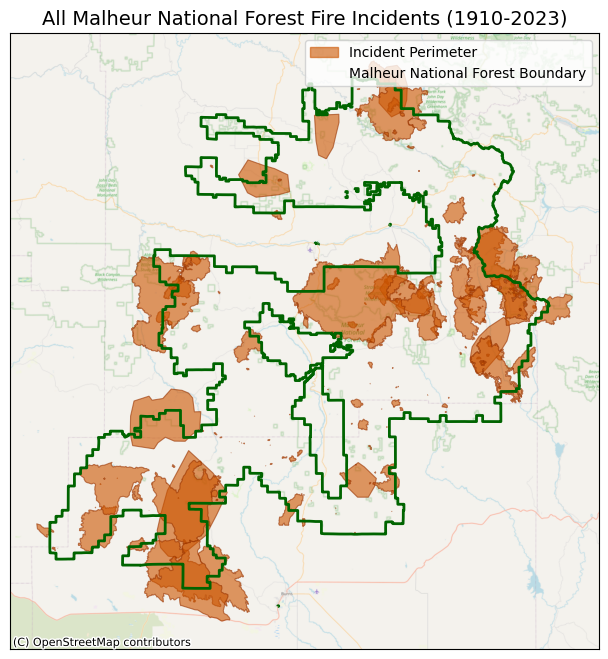

In [16]:
# Define colors
fill_color = "#CC5500"  # Burnt Orange (fire perimeters)
edge_color = "#993300"  # Dark Orange (fire outlines)
boundary_edge_color = "#006400"  # Dark Green (Malheur boundary)

# Ensure GeoDataFrames are in Web Mercator (EPSG:3857) for basemap compatibility
mnf_fires_all = mnf_fires_all.to_crs(epsg = 3857)
mnf_bounds = mnf_bounds.to_crs(epsg = 3857)

# Create the figure and axis
fig, ax = plt.subplots(figsize = (10, 8))

# Plot the fire perimeters
mnf_fires_cleaned.plot(ax = ax, color = fill_color, edgecolor = edge_color, alpha = 0.6, linewidth = 0.8)

# Plot Malheur National Forest boundary with no fill, only dark green outline
mnf_bounds.plot(ax = ax, color = "none", edgecolor = boundary_edge_color, linewidth = 2)

# Add basemap
ctx.add_basemap(ax, source = ctx.providers.OpenStreetMap.Mapnik, zoom = 10, alpha = 0.8)

# Add a custom legend
legend_patches = [
    mpatches.Patch(color = fill_color, label = "Incident Perimeter", alpha = 0.6, edgecolor = edge_color),
    mpatches.Patch(color = "none", edgecolor = boundary_edge_color, label = "Malheur National Forest Boundary", linewidth = 2)
]
ax.legend(handles = legend_patches, loc = "upper right")

# Title and axis labels
ax.set_title("All Malheur National Forest Fire Incidents (1910-2023)", fontsize = 14)

# Remove axis labels (optional, since basemap provides context)
ax.set_xticks([])
ax.set_yticks([])

# Show plot
plt.show()

In [17]:
mnf_fires_cleaned = mnf_fires_cleaned.sort_values(by = "GIS_ACRES", ascending = False)
mnf_fires_cleaned.describe()

,OBJECTID,FIRE_YEAR,GIS_ACRES,FIRE_YEAR_,Shape__Are,Shape__Len,index_right,area
count,165.000000,165.000000,165.000000,165.000000,1.650000e+02,165.000000,165.0,1.650000e+02
mean,17658.612121,1996.496970,6000.935576,1996.496970,4.717159e+07,25482.577307,65.0,4.721953e+07
std,20761.372240,26.021713,15718.588465,26.021713,1.232276e+08,48004.961857,0.0,1.232624e+08
min,620.000000,1910.000000,0.020000,1910.000000,1.411641e+02,54.632114,65.0,1.411386e+02
25%,3312.000000,1990.000000,11.000000,1990.000000,8.886149e+04,1416.919005,65.0,8.886150e+04
50%,3712.000000,2002.000000,131.000000,2002.000000,1.039576e+06,6015.983562,65.0,1.039576e+06
75%,32222.000000,2014.000000,1594.490000,2014.000000,1.236467e+07,25548.145302,65.0,1.236467e+07
max,80841.000000,2023.000000,110274.000000,2023.000000,8.711610e+08,297076.529997,65.0,8.711610e+08


In [18]:
recent_mnf_fires = mnf_fires_cleaned[mnf_fires_cleaned["FIRE_YEAR"] >= 1980] 
total_acres_burned = recent_mnf_fires["GIS_ACRES"].sum()
print(total_acres_burned)
recent_mnf_fires

717852.37


,OBJECTID,MAP_METHOD,DATE_CUR,COMMENTS,GEO_ID,IRWINID,UNQE_FIRE_,FIRE_YEAR,LOCAL_NUM,INCIDENT,...,AGENCY,FIRE_YEAR_,Shape__Are,Shape__Len,FORID,OTHERID,index_right,FORESTNAME,geometry,area
176,3723,Remote Sensing Data - Base Level,201603010000,Complex was comprised of Mason Spring and Berr...,{AAFAD12E-1AF6-4F3D-A442-ECEA014DE126},None,2015-ORMAF-000192,2015,None,Canyon Creek Complex,...,USFS,2015,8.711610e+08,242068.090227,None,None,65.0,Malheur National Forest,"MULTIPOLYGON (((-13213889.173 5527967.974, -13...",8.711610e+08
42,32223,Other,200805290000,From old Snow Mountain district library,{C197950F-6E11-477F-82CF-CB3E91C2EB6A},None,None,1990,None,Pine Springs,...,USFS,1990,5.550997e+08,190135.577427,None,None,65.0,Malheur National Forest,"POLYGON ((-13284244.515 5412897.496, -13284229...",5.550997e+08
168,3596,Remote Sensing Data - Base Level,201502100000,Fire not in IRWIN,{5FB8ECF9-19A2-4735-AC67-1263DFA95EE8},None,2014-ORMAF-000130,2014,None,Murders Creek South,...,USFS,2014,5.222610e+08,175521.369001,None,None,65.0,Malheur National Forest,"MULTIPOLYGON (((-13301539.191 5525586.776, -13...",5.222610e+08
132,3313,Other,200805290000,"Egley fire Complex, OR-BFZ-7148, IC: Higle, Ca...",{EE4465E8-FC08-4038-B9DF-E95DA3E6D434},None,2007-ORMAF-000167,2007,070,Egley,...,USFS,2007,4.278867e+08,139870.994989,None,None,65.0,Malheur National Forest,"POLYGON ((-13284495.763 5413170.228, -13284280...",4.278867e+08
139,17867,Other,200805290000,OR-BFZ-7177 IC: Towers Grew together with Egley,{AE7C57B3-09EA-4D19-8338-1843071EC355},None,2007-ORMAF-000090,2007,23,Bear Canyon,...,USFS,2007,4.104031e+08,149197.022840,None,None,65.0,Malheur National Forest,"POLYGON ((-13296131.357 5441288.001, -13296125...",4.104031e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55,62092,Other,199206260000,None,{06BEA277-16FE-4FD3-99DA-ADA0DD38ED46},None,1992-ORVAD-000000,1992,0,WWF3,...,BLM,1992,7.895859e+02,99.624004,None,None,65.0,Malheur National Forest,"POLYGON ((-13161792.584 5509392.775, -13161791...",7.895343e+02
203,1053,GPS - Differentially Corrected Data,202110011529,None,{53A8A768-9B34-48E7-99E6-A446613CF516},{4270417E-4E90-4EA9-A8A1-3D8D364E1AF6},2021-ORMAF-002236,2021,None,Magpie,...,USFS,2021,7.142266e+02,162.130334,{B36DFC84-474F-49A7-851F-DE378CAA1D7F},None,65.0,Malheur National Forest,"POLYGON ((-13213767.579 5470437.961, -13213756...",7.142190e+02
197,1031,GPS - Differentially Corrected Data,202112031542,None,{6E1E3E61-3EF7-4EC8-9441-40A6170876FE},{9BFA7B7E-104F-4AE9-8369-5413C10B018B},2021-ORMAF-002162,2021,None,West Myrtle,...,USFS,2021,4.947812e+02,104.719074,{299E5293-1E37-4670-BAD9-1AB1B803FB61},None,65.0,Malheur National Forest,"POLYGON ((-13259173.886 5456272.829, -13259171...",4.947784e+02
199,1042,GPS - Differentially Corrected Data,202112031710,None,{A75DA359-81BC-4E92-8C51-ECB5A0D5D8FF},{7141B833-0148-488F-9223-C056D4ADD382},2021-ORMAF-002138,2021,None,Sage Hen,...,USFS,2021,2.898203e+02,65.822132,{D15E7C70-FF77-48D9-AE9B-78A8E8C250F1},None,65.0,Malheur National Forest,"POLYGON ((-13272231.64 5445162.032, -13272231....",2.898233e+02


**Subset only big (>= 1,000 acres) and recent (1980 to 2023) incidents.**

In [19]:
big_mnf_fires = mnf_fires_cleaned[(mnf_fires_cleaned["GIS_ACRES"] >= 1000) & (mnf_fires_cleaned["FIRE_YEAR"] >= 1980)] # These fires should have MTBS data
big_mnf_fires.head()

,OBJECTID,MAP_METHOD,DATE_CUR,COMMENTS,GEO_ID,IRWINID,UNQE_FIRE_,FIRE_YEAR,LOCAL_NUM,INCIDENT,...,AGENCY,FIRE_YEAR_,Shape__Are,Shape__Len,FORID,OTHERID,index_right,FORESTNAME,geometry,area
176,3723,Remote Sensing Data - Base Level,201603010000,Complex was comprised of Mason Spring and Berr...,{AAFAD12E-1AF6-4F3D-A442-ECEA014DE126},None,2015-ORMAF-000192,2015,None,Canyon Creek Complex,...,USFS,2015,8.711610e+08,242068.090227,None,None,65.0,Malheur National Forest,"MULTIPOLYGON (((-13213889.173 5527967.974, -13...",8.711610e+08
42,32223,Other,200805290000,From old Snow Mountain district library,{C197950F-6E11-477F-82CF-CB3E91C2EB6A},None,None,1990,None,Pine Springs,...,USFS,1990,5.550997e+08,190135.577427,None,None,65.0,Malheur National Forest,"POLYGON ((-13284244.515 5412897.496, -13284229...",5.550997e+08
168,3596,Remote Sensing Data - Base Level,201502100000,Fire not in IRWIN,{5FB8ECF9-19A2-4735-AC67-1263DFA95EE8},None,2014-ORMAF-000130,2014,None,Murders Creek South,...,USFS,2014,5.222610e+08,175521.369001,None,None,65.0,Malheur National Forest,"MULTIPOLYGON (((-13301539.191 5525586.776, -13...",5.222610e+08
132,3313,Other,200805290000,"Egley fire Complex, OR-BFZ-7148, IC: Higle, Ca...",{EE4465E8-FC08-4038-B9DF-E95DA3E6D434},None,2007-ORMAF-000167,2007,070,Egley,...,USFS,2007,4.278867e+08,139870.994989,None,None,65.0,Malheur National Forest,"POLYGON ((-13284495.763 5413170.228, -13284280...",4.278867e+08
139,17867,Other,200805290000,OR-BFZ-7177 IC: Towers Grew together with Egley,{AE7C57B3-09EA-4D19-8338-1843071EC355},None,2007-ORMAF-000090,2007,23,Bear Canyon,...,USFS,2007,4.104031e+08,149197.022840,None,None,65.0,Malheur National Forest,"POLYGON ((-13296131.357 5441288.001, -13296125...",4.104031e+08


Fires smaller than 1,000 acres lack supporting documentation needed for a robust severity analysis of historical incidentsand are not the target of this project. To check the validity of excluding small (< 1,000 acres) from the analysis, we checked the percentage of total burned area in MNF since 1980 that was burned as part of a large fire.

In [20]:
recent_total_acres_burned = recent_mnf_fires["GIS_ACRES"].sum()
print(recent_total_acres_burned)
big_total_acres_burned = big_mnf_fires["GIS_ACRES"].sum()
print(big_total_acres_burned)
percent_big_area_burned = (big_total_acres_burned / recent_total_acres_burned) * 100
percent_big_area_burned

717852.37
703206.3500000001


np.float64(97.95974484280104)

97.9% of all area burned in MNF since 1980 was burned as part of a large fire, suggesting that there were few small fires and it is reasonable to exclude them from the analysis. This percentage is likely a bit off since some areas could reburn. However, reburn in 40 years is uncommon.
**We should use the mask to determine this to negate overlap.**

# Subset case study fires

In [29]:
# Big fires post-1980 except Powell fires
fires_1980_to_2008 = big_mnf_fires[(big_mnf_fires["FIRE_YEAR"] >= 1980) & (big_mnf_fires["FIRE_YEAR"] <= 2008)]
fires_1980_to_2008 = fires_1980_to_2008[~fires_1980_to_2008['INCIDENT'].isin(['Glacier', 'Corral Basin', 'Snowshoe', 'Sheep Mountain', 'Whiting Springs'])]
fires_1980_to_2008

,OBJECTID,MAP_METHOD,DATE_CUR,COMMENTS,GEO_ID,IRWINID,UNQE_FIRE_,FIRE_YEAR,LOCAL_NUM,INCIDENT,...,AGENCY,FIRE_YEAR_,Shape__Are,Shape__Len,FORID,OTHERID,index_right,FORESTNAME,geometry,area
42,32223,Other,200805290000,From old Snow Mountain district library,{C197950F-6E11-477F-82CF-CB3E91C2EB6A},None,None,1990,None,Pine Springs,...,USFS,1990,5.550997e+08,190135.577427,None,None,65.0,Malheur National Forest,"POLYGON ((-13284244.515 5412897.496, -13284229...",5.550997e+08
132,3313,Other,200805290000,"Egley fire Complex, OR-BFZ-7148, IC: Higle, Ca...",{EE4465E8-FC08-4038-B9DF-E95DA3E6D434},None,2007-ORMAF-000167,2007,070,Egley,...,USFS,2007,4.278867e+08,139870.994989,None,None,65.0,Malheur National Forest,"POLYGON ((-13284495.763 5413170.228, -13284280...",4.278867e+08
139,17867,Other,200805290000,OR-BFZ-7177 IC: Towers Grew together with Egley,{AE7C57B3-09EA-4D19-8338-1843071EC355},None,2007-ORMAF-000090,2007,23,Bear Canyon,...,USFS,2007,4.104031e+08,149197.022840,None,None,65.0,Malheur National Forest,"POLYGON ((-13296131.357 5441288.001, -13296125...",4.104031e+08
71,3670,Other,200805290000,None,{956C1A83-E598-48FE-ABC9-782B5DB0E7AA},None,1996-ORUMF-000047,1996,None,Summit,...,USFS,1996,3.045835e+08,117602.874380,None,None,65.0,Malheur National Forest,"MULTIPOLYGON (((-13208418.444 5574728.24, -132...",3.045835e+08
140,3242,Other,200805290000,Part of Egley ComplexOR-BFZ-7179IC: SchmidIC: ...,{D313710C-8D80-4F2B-A80D-80C274169CB1},None,2007-ORMAF-000151,2007,054,Silver Fire,...,USFS,2007,2.459465e+08,84060.593160,None,None,65.0,Malheur National Forest,"POLYGON ((-13316535.334 5430794.366, -13316562...",2.459465e+08
102,32474,GPS - Uncorrected Data,200805290000,None,{2F294F74-22A8-42B1-8F1A-7C3530ACBA52},None,2002-ORMAF-000048,2002,None,Monument,...,USFS,2002,1.938219e+08,105627.088678,None,None,65.0,Malheur National Forest,"MULTIPOLYGON (((-13160579.716 5513835.445, -13...",1.938219e+08
48,3311,Other,200805290000,From old Snow Mountain district library,{D74FBB06-25A8-4955-87B2-F74D34D53A43},None,None,1990,None,Buck Springs,...,USFS,1990,1.609660e+08,73658.537925,None,None,65.0,Malheur National Forest,"POLYGON ((-13321212.071 5432729.181, -13321192...",1.609660e+08
117,32218,GPS - Uncorrected Data,200805290000,None,{D185B697-DCAD-4F59-B889-04266F3BDF36},None,2006-ORMAF-000267,2006,None,Thorn Creek,...,USFS,2006,1.149684e+08,68562.696850,None,None,65.0,Malheur National Forest,"POLYGON ((-13292820.493 5516401.944, -13292739...",1.149684e+08
98,3239,GPS - Uncorrected Data,200805290000,None,{8AC69262-FE73-4149-B1EF-923FFF04292D},None,2002-ORMAF-000052,2002,None,High Roberts,...,USFS,2002,1.069198e+08,67790.008391,None,None,65.0,Malheur National Forest,"POLYGON ((-13200258.74 5511067.878, -13200277....",1.069198e+08
38,32468,Other,200805290000,None,{4C3A81D2-CDFE-445C-9152-4613A463C8EF},None,1989-ORWWF-000377,1989,None,Monument Rock,...,USFS,1989,9.980943e+07,52192.985001,None,None,65.0,Malheur National Forest,"POLYGON ((-13164043.784 5516602.055, -13164048...",9.980943e+07


**There were 24 large fires in MNF from 1980-2008 (excluding the 5 Powell fires).**

In [28]:
# "Severe" fires identified in Powell 1994
powell_fires = big_mnf_fires[big_mnf_fires['INCIDENT'].isin(['Glacier', 'Corral Basin', 'Snowshoe', 'Sheep Mountain', 'Whiting Springs'])]
powell_fires

,OBJECTID,MAP_METHOD,DATE_CUR,COMMENTS,GEO_ID,IRWINID,UNQE_FIRE_,FIRE_YEAR,LOCAL_NUM,INCIDENT,...,AGENCY,FIRE_YEAR_,Shape__Are,Shape__Len,FORID,OTHERID,index_right,FORESTNAME,geometry,area
45,3339,Other,200805290000,None,{5DA44F9E-C7B2-47B2-A9A9-5D7F0A39C1B4},None,1990-ORMAF-000069,1990,None,Snowshoe,...,USFS,1990,9.332320e+07,64421.896859,None,None,65.0,Malheur National Forest,"POLYGON ((-13199244.948 5512696.342, -13199156...",9.332320e+07
41,32473,Other,200805290000,None,{4F0FDFBF-E45C-4ACC-B3EA-7F0A2174EDF2},None,1990-ORMAF-000135,1990,None,Sheep Mountain,...,USFS,1990,8.659839e+07,62829.213364,None,None,65.0,Malheur National Forest,"POLYGON ((-13191219.548 5500453.583, -13191245...",8.659839e+07
39,4512,Other,200805290000,None,{71BBAD01-679F-4340-A397-CBAB397E7ED3},None,None,1989,None,Glacier,...,USFS,1989,7.373552e+07,53976.856705,None,None,65.0,Malheur National Forest,"POLYGON ((-13185096.453 5511146.029, -13185126...",7.373552e+07
40,40142,Other,200805290000,None,{5F1E4DD6-E6CD-4ED9-952E-17F1A0E11A7E},None,1990-ORMAF-000064,1990,None,Whiting Springs,...,USFS,1990,4.366926e+07,36623.693481,None,None,65.0,Malheur National Forest,"POLYGON ((-13252376.493 5426819.177, -13253831...",4.366926e+07
46,3713,Other,200805290000,None,{A8282EFD-CDC0-421F-A225-88C87C44C134},None,1990-ORMAF-000033,1990,None,Corral Basin,...,USFS,1990,8.945688e+06,17745.890788,None,None,65.0,Malheur National Forest,"POLYGON ((-13197653.926 5499727.164, -13197759...",8.945688e+06


/tmp/ipykernel_1220/3857478525.py:21: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  mpatches.Patch(color = "#CC5500", label = "Powell fires", alpha = 0.6, edgecolor = "#993300"),
/tmp/ipykernel_1220/3857478525.py:22: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  mpatches.Patch(color = "#e7b1cb", label = "1980-2008 big fires", alpha = 0.6, edgecolor = "#9c3064"),


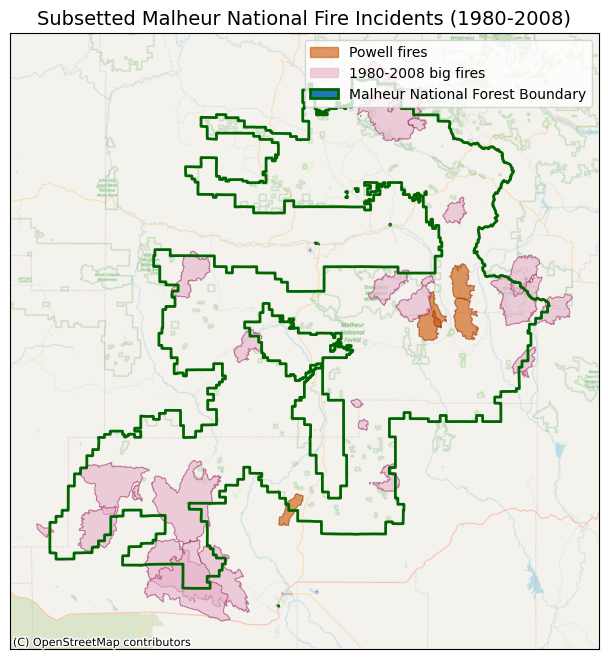

In [40]:
# Define colors
fill_color = "#CC5500"  # Burnt Orange (fire perimeters)
edge_color = "#993300"  # Dark Orange (fire outlines)
boundary_edge_color = "#006400"  # Dark Green (Malheur boundary)

# Create the figure and axis
fig, ax = plt.subplots(figsize = (10, 8))

# Plot the fire perimeters
powell_fires.plot(ax = ax, color = "#CC5500", edgecolor = "#993300", alpha = 0.6, linewidth = 0.8)
fires_1980_to_2008.plot(ax = ax, color = "#e7b1cb" , edgecolor = "#9c3064", alpha = 0.6, linewidth = 0.8)

# Plot Malheur National Forest boundary with no fill, only dark green outline
mnf_bounds.plot(ax = ax, color = "none", edgecolor = "#006400", linewidth = 2)

# Add basemap
ctx.add_basemap(ax, source = ctx.providers.OpenStreetMap.Mapnik, zoom = 10, alpha = 0.8)

# Add a custom legend
legend_patches = [
    mpatches.Patch(color = "#CC5500", label = "Powell fires", alpha = 0.6, edgecolor = "#993300"),
    mpatches.Patch(color = "#e7b1cb", label = "1980-2008 big fires", alpha = 0.6, edgecolor = "#9c3064"),
    mpatches.Patch(edgecolor = "#006400", label = "Malheur National Forest Boundary", linewidth = 2)
]
ax.legend(handles = legend_patches, loc = "upper right")

# Title and axis labels
ax.set_title("Subsetted Malheur National Fire Incidents (1980-2008)", fontsize = 14)

# Remove axis labels (optional, since basemap provides context)
ax.set_xticks([])
ax.set_yticks([])

# Show plot
plt.show()

# Powell fires

**Determine which of the Powell fires is the isolated feature on the MNF southern boarder and exclude from analysis. A large extent 

In [23]:
# Combine all MNF boundary geometries into a single geometry
mnf_union = shapely.union_all(mnf_bounds.geometry.values)

# Find features in powell_fires that are entirely within the MNF boundary
contained_fires = powell_fires[powell_fires.geometry.within(mnf_union)]
contained_fires

,OBJECTID,MAP_METHOD,DATE_CUR,COMMENTS,GEO_ID,IRWINID,UNQE_FIRE_,FIRE_YEAR,LOCAL_NUM,INCIDENT,...,AGENCY,FIRE_YEAR_,Shape__Are,Shape__Len,FORID,OTHERID,index_right,FORESTNAME,geometry,area
45,3339,Other,200805290000,None,{5DA44F9E-C7B2-47B2-A9A9-5D7F0A39C1B4},None,1990-ORMAF-000069,1990,None,Snowshoe,...,USFS,1990,9.332320e+07,64421.896859,None,None,65.0,Malheur National Forest,"POLYGON ((-13199244.948 5512696.342, -13199156...",9.332320e+07
41,32473,Other,200805290000,None,{4F0FDFBF-E45C-4ACC-B3EA-7F0A2174EDF2},None,1990-ORMAF-000135,1990,None,Sheep Mountain,...,USFS,1990,8.659839e+07,62829.213364,None,None,65.0,Malheur National Forest,"POLYGON ((-13191219.548 5500453.583, -13191245...",8.659839e+07
39,4512,Other,200805290000,None,{71BBAD01-679F-4340-A397-CBAB397E7ED3},None,None,1989,None,Glacier,...,USFS,1989,7.373552e+07,53976.856705,None,None,65.0,Malheur National Forest,"POLYGON ((-13185096.453 5511146.029, -13185126...",7.373552e+07
46,3713,Other,200805290000,None,{A8282EFD-CDC0-421F-A225-88C87C44C134},None,1990-ORMAF-000033,1990,None,Corral Basin,...,USFS,1990,8.945688e+06,17745.890788,None,None,65.0,Malheur National Forest,"POLYGON ((-13197653.926 5499727.164, -13197759...",8.945688e+06


**Only include incidents with 75% of their extent inside MNF.**

In [42]:
# Ensure CRS matches
fires_1980_to_2008 = fires_1980_to_2008.to_crs(mnf_bounds.crs)

# Create a unioned geometry from mnf_bounds
if isinstance(mnf_bounds, gpd.GeoDataFrame):
    mnf_union = mnf_bounds.geometry.unary_union
else:
    mnf_union = mnf_bounds

# Compute intersection and area ratio
fires_1980_to_2008['intersection'] = fires_1980_to_2008.geometry.intersection(mnf_union)
fires_1980_to_2008['intersection_area'] = fires_1980_to_2008['intersection'].area
fires_1980_to_2008['original_area'] = fires_1980_to_2008.geometry.area
fires_1980_to_2008['area_ratio'] = fires_1980_to_2008['intersection_area'] / fires_1980_to_2008['original_area']

# Filter for features where >75% of area lies within mnf_bounds
fires_75_within = fires_1980_to_2008[fires_1980_to_2008['area_ratio'] > 0.75]
fires_75_within

/tmp/ipykernel_1220/2950274630.py:8: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  mnf_union = mnf_bounds.geometry.unary_union


,OBJECTID,MAP_METHOD,DATE_CUR,COMMENTS,GEO_ID,IRWINID,UNQE_FIRE_,FIRE_YEAR,LOCAL_NUM,INCIDENT,...,FORID,OTHERID,index_right,FORESTNAME,geometry,area,intersection,intersection_area,original_area,area_ratio
139,17867,Other,200805290000,OR-BFZ-7177 IC: Towers Grew together with Egley,{AE7C57B3-09EA-4D19-8338-1843071EC355},None,2007-ORMAF-000090,2007,23,Bear Canyon,...,None,None,65.0,Malheur National Forest,"POLYGON ((-13296131.357 5441288.001, -13296125...",4.104031e+08,"POLYGON ((-13296125.732 5441280.326, -13296101...",3.791538e+08,4.104031e+08,0.923857
71,3670,Other,200805290000,None,{956C1A83-E598-48FE-ABC9-782B5DB0E7AA},None,1996-ORUMF-000047,1996,None,Summit,...,None,None,65.0,Malheur National Forest,"MULTIPOLYGON (((-13208418.444 5574728.24, -132...",3.045835e+08,"MULTIPOLYGON (((-13208405.904 5574721.41, -132...",2.399012e+08,3.045835e+08,0.787637
140,3242,Other,200805290000,Part of Egley ComplexOR-BFZ-7179IC: SchmidIC: ...,{D313710C-8D80-4F2B-A80D-80C274169CB1},None,2007-ORMAF-000151,2007,054,Silver Fire,...,None,None,65.0,Malheur National Forest,"POLYGON ((-13316535.334 5430794.366, -13316562...",2.459465e+08,"POLYGON ((-13316562.189 5430790.608, -13316632...",2.458136e+08,2.459465e+08,0.999460
102,32474,GPS - Uncorrected Data,200805290000,None,{2F294F74-22A8-42B1-8F1A-7C3530ACBA52},None,2002-ORMAF-000048,2002,None,Monument,...,None,None,65.0,Malheur National Forest,"MULTIPOLYGON (((-13160579.716 5513835.445, -13...",1.938219e+08,"MULTIPOLYGON (((-13160792.26 5510238.772, -131...",1.594431e+08,1.938219e+08,0.822627
48,3311,Other,200805290000,From old Snow Mountain district library,{D74FBB06-25A8-4955-87B2-F74D34D53A43},None,None,1990,None,Buck Springs,...,None,None,65.0,Malheur National Forest,"POLYGON ((-13321212.071 5432729.181, -13321192...",1.609660e+08,"POLYGON ((-13321192.777 5432743.805, -13321093...",1.371862e+08,1.609660e+08,0.852268
117,32218,GPS - Uncorrected Data,200805290000,None,{D185B697-DCAD-4F59-B889-04266F3BDF36},None,2006-ORMAF-000267,2006,None,Thorn Creek,...,None,None,65.0,Malheur National Forest,"POLYGON ((-13292820.493 5516401.944, -13292739...",1.149684e+08,"POLYGON ((-13292739.948 5516491.48, -13292627....",1.071240e+08,1.149684e+08,0.931769
98,3239,GPS - Uncorrected Data,200805290000,None,{8AC69262-FE73-4149-B1EF-923FFF04292D},None,2002-ORMAF-000052,2002,None,High Roberts,...,None,None,65.0,Malheur National Forest,"POLYGON ((-13200258.74 5511067.878, -13200277....",1.069198e+08,"POLYGON ((-13200277.006 5511061.207, -13200429...",1.069198e+08,1.069198e+08,1.000000
73,3241,Other,200805290000,None,{FB4D5E3F-19C0-42F1-BAE3-B2891D302F8F},None,1996-ORMAF-000019,1996,None,Wildcat,...,None,None,65.0,Malheur National Forest,"MULTIPOLYGON (((-13213723.924 5518497.324, -13...",8.414642e+07,"MULTIPOLYGON (((-13213707.786 5518510.362, -13...",8.197075e+07,8.414642e+07,0.974144
91,2784,GPS - Uncorrected Data,200805290000,None,{08163E2C-CA0B-44E1-8932-9015BECC67E1},None,2002-ORMAF-000085,2002,None,Flagtail,...,None,None,65.0,Malheur National Forest,"POLYGON ((-13267277.767 5498105.648, -13267178...",6.410328e+07,"POLYGON ((-13267178.551 5498363.467, -13267106...",5.663737e+07,6.410328e+07,0.883533
97,3655,Photogrammetric Compilation,200805290000,None,{9A08CB3C-B58F-415F-9067-3A9B48A0399B},None,2002-ORMAF-000049,2002,None,Easy,...,None,None,65.0,Malheur National Forest,"POLYGON ((-13190264.07 5545854.578, -13190215....",4.646569e+07,"POLYGON ((-13190215.141 5545855.482, -13190171...",4.646569e+07,4.646569e+07,1.000000


In [24]:
# 39 big fires since 1980
# MNF 695,501.58 hectares / 1,718,619.18 acres

# Group by INCIDENT_YEAR and count occurrences using agg
yearly_fire_counts = big_mnf_fires.groupby("FIRE_YEAR").agg(count=("FIRE_YEAR", "count")).reset_index()

# Display the result
print(yearly_fire_counts)

    FIRE_YEAR  count
0        1986      2
1        1989      2
2        1990      7
3        1994      5
4        1996      2
5        2002      4
6        2006      2
7        2007      5
8        2009      1
9        2010      1
10       2011      1
11       2012      1
12       2014      2
13       2015      1
14       2016      1
15       2019      1
16       2021      2


/tmp/ipykernel_1220/2701657613.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("YlOrRd")  # Yellow-Orange-Red colormap for fire visualization
/tmp/ipykernel_1220/2701657613.py:44: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  mpatches.Patch(color="none", edgecolor=boundary_edge_color, label="Malheur National Forest Boundary", linewidth=2)


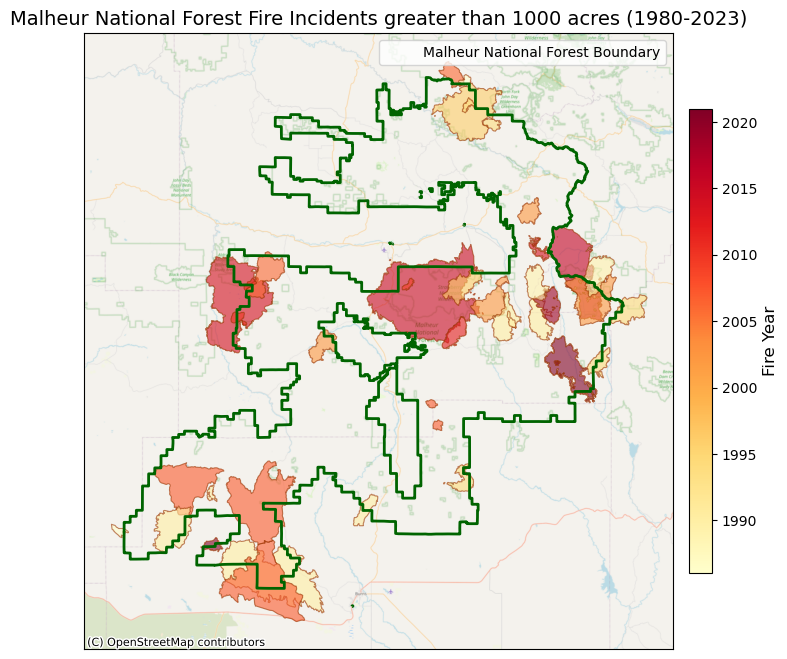

In [25]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Define colors for outlines and boundaries
edge_color = "#993300"  # Dark Orange (fire outlines)
boundary_edge_color = "#006400"  # Dark Green (Malheur boundary)

# Ensure GeoDataFrames are in Web Mercator (EPSG:3857) for basemap compatibility
mnf_fires_all = mnf_fires_all.to_crs(epsg=3857)
mnf_bounds = mnf_bounds.to_crs(epsg=3857)
big_mnf_fires = big_mnf_fires.to_crs(epsg=3857)

# Normalize the FIRE_YEAR to a color scale
norm = mcolors.Normalize(vmin=big_mnf_fires["FIRE_YEAR"].min(), vmax=big_mnf_fires["FIRE_YEAR"].max())
cmap = cm.get_cmap("YlOrRd")  # Yellow-Orange-Red colormap for fire visualization

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Plot fire perimeters with color ramp based on FIRE_YEAR
for _, row in big_mnf_fires.iterrows():
    fire_color = cmap(norm(row["FIRE_YEAR"]))  # Get color based on year
    row_geometry = row["geometry"]
    gpd.GeoSeries(row_geometry).plot(ax=ax, color=fire_color, edgecolor=edge_color, alpha=0.6, linewidth=0.8)

# Plot Malheur National Forest boundary with no fill, only dark green outline
mnf_bounds.plot(ax=ax, color="none", edgecolor=boundary_edge_color, linewidth=2)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=10, alpha=0.8)

# Create colorbar for the FIRE_YEAR gradient
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation="vertical", fraction=0.03, pad=0.02)
cbar.set_label("Fire Year", fontsize=12)

# Add a custom legend for boundary
legend_patches = [
    mpatches.Patch(color="none", edgecolor=boundary_edge_color, label="Malheur National Forest Boundary", linewidth=2)
]
ax.legend(handles=legend_patches, loc="upper right")

# Title and axis labels
ax.set_title("Malheur National Forest Fire Incidents greater than 1000 acres (1980-2023)", fontsize=14)

# Remove axis labels (optional, since basemap provides context)
ax.set_xticks([])
ax.set_yticks([])

# Show plot
plt.show()


## Fire frequency raster

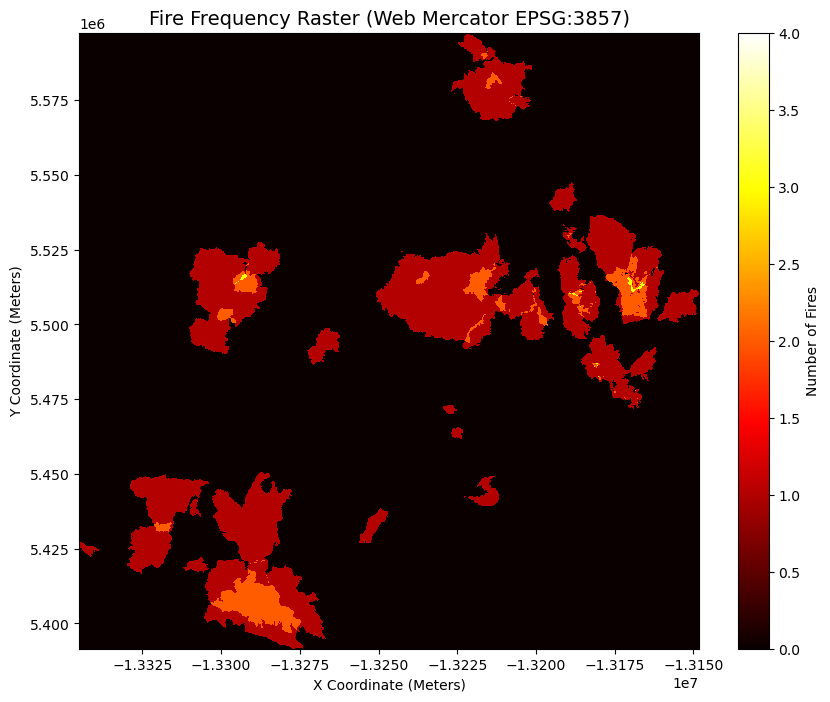

In [26]:
import numpy as np
import rasterio
from rasterio.features import rasterize
from rasterio.transform import from_bounds
import matplotlib.pyplot as plt

# Define raster resolution (adjust cell size as needed, in meters)
cell_size = 100  # Each pixel represents 100x100 meters

# Get bounding box of the study area (in Web Mercator meters)
minx, miny, maxx, maxy = big_mnf_fires.total_bounds

# Define raster dimensions
width = int((maxx - minx) / cell_size)
height = int((maxy - miny) / cell_size)

# Define transformation matrix (maps pixel indices to spatial coordinates)
transform = from_bounds(minx, miny, maxx, maxy, width, height)

# Rasterize fire perimeters (counting occurrences)
fire_raster = rasterize(
    [(geom, 1) for geom in big_mnf_fires.geometry],  
    out_shape=(height, width),
    transform=transform,
    all_touched=True,  
    merge_alg=rasterio.enums.MergeAlg.add  
)

# Convert to NumPy array
fire_array = np.array(fire_raster)

# Generate x and y coordinate arrays in meters (Web Mercator)
x_coords = np.linspace(minx, maxx, width)
y_coords = np.linspace(maxy, miny, height)  # Reverse Y to match raster grid

# Create a meshgrid of Web Mercator coordinates
X, Y = np.meshgrid(x_coords, y_coords)

# Plot using real-world coordinates in Web Mercator (meters)
fig, ax = plt.subplots(figsize=(10, 8))
c = ax.pcolormesh(X, Y, fire_array, cmap="hot", shading="auto")

# Add colorbar
plt.colorbar(c, ax=ax, label="Number of Fires")

# Title and Labels (Now correctly labeled in meters)
ax.set_title("Fire Frequency Raster (Web Mercator EPSG:3857)", fontsize=14)
ax.set_xlabel("X Coordinate (Meters)")
ax.set_ylabel("Y Coordinate (Meters)")

# Show plot
plt.show()
